# <font color=purple>Research Question - Use Cases</font>

## <font color=purple>Background</font>

Below are some research questions in demonstrating different use cases.

1. **<font color=blue>What are the trends of people's occupations over the years between 1980's to 2020's?</font>**
2. Are there more older people who work in professional roles?
3. What is the age of people who is born outside of mainland China?
4. Are there more younger people who was born Hong Kong than in mainland China?
5. What are the differences in occupations between older people who were born in Taiwan and mainland China?
6. Are there more younger people who have a university degree and who was born in Hong Kong?
7. Does people who work in professional roles will have less children?

In order to address these questions, you'll need to install and connect to a graph database instance to pull out the data to perform the analysis using machine learning and other AI approaches. Variables are based on the  volcabulary. Below are some of the variables of interest for the above research questions:

- _Reference Date of Dataset_
- _Date of Birth (derive Age)_
- _Place of Birth_
- _Occupation_
- _Credential_
- _Children_

This tutorial will perform a series of data profiling, multivariate analysis, time series, etc. including using data visualisations, to address each research question. A summary of each analysis will be used to describe the relevant analysis.

### Installing Python and AllegroGraph

The script requires setting up the Python 3 environment. You should setup a virtual machine to ensure all Python 3 dependencies are installed and self-contained. The script also requires setting up AllegroGraph into the Python environment. [AllegraGraph](https://allegrograph.com/products/allegrograph/) is a document-centric graph database that allows researchers and AI practitioners the ability to perform SPARQL queries on heterogeneous data using _Resource Description Framework (RDF)_. More information about the development environment can be found [here](http://#).
 
### Ingesting Data into Graph Database Instance (Local/Remote)

After setting up Python and AllegroGraph environment, you'll need to import data into the graph database (AllegroGraph) instance whether this is running on your local machine or in the cloud. You can pull the necessary resources from the project's Github. A folder called `/ingestion` contains all of the JSON-LD data files. The JSON-LD files contains the relevant RDF encodings including the links to the relevant ontologies. Our system builds on the [Schema.org](https://schema.org) volcabulary. More information about the respository and graph data platform can be found [here](http://#).

## <font color=purple>Import Libraries</font>

To begin, you'll need to import python libraries in order to be able to connect to the graph database to extract data, perform queries, perform any transformation, and to plot and analyse the data. 

In [574]:
# file processing and database
from franz.openrdf.connect import ag_connect
from franz.openrdf.query.query import QueryLanguage
import json
import os
import pandas as pd
import numpy as np

# NLP
from nlp_utils import *
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
import math

# ML
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
import seaborn as sns
from IPython.display import display, HTML

[nltk_data] Downloading package stopwords to /Users/b/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/b/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## <font color=purple>SPARQL Query for Research Questions

In order to develop the dataset(s) to address each of the above research questions, you need to develop several SPARQL queries. [SPARQL](https://www.w3.org/TR/rdf-sparql-query/) is a query language used for retrieving RDF data.  Datasets will depend on the research question, such as data profiling, time-series or multivariate analysis. A full list of SPARQL queries for these notes can be found [here](https://#/).

### SPARQL query for Research Question 1

In [2]:
query_string_1_1 = """
    PREFIX cwork: <http://schema.org/CreativeWork>
    PREFIX per: <http://schema.org/Person>

    # View triples
    SELECT (SAMPLE(?_year) AS $year)
           (SAMPLE(?_wave) AS $wave)
           (COUNT(?_contributor) AS $participant_count) 
    WHERE 
    {
      ?Dataset cwork:name $object ;
               cwork:contentReferenceTime ?_year ;
               cwork:identifier ?_wave ;
               cwork:contributor ?_contributor . 
    }
    GROUP BY ?Dataset
    ORDER BY ?_year
"""

query_string_1_2 = """
    PREFIX cwork: <http://schema.org/CreativeWork>

    # View triples
    SELECT ?_contributor ?_year ?_wave
    WHERE
    { 
        ?Dataset cwork:name $object ;
                 cwork:contentReferenceTime ?_year ;
                 cwork:identifier ?_wave ;
                 cwork:contributor ?_contributor . 
    } ORDER BY ?_year
"""

query_string_1_3 = """
    PREFIX per: <http://schema.org/Person>
    PREFIX occ: <http://schema.org/Occupation>

    # View triples
    SELECT DISTINCT ?_identifier ?_occupation_name
    WHERE
    { 
        ?subject a ?Person ;
                 per:identifier ?_identifier ;
                 per:hasOccupation ?_occupation .
        ?_occupation occ:name ?_occupation_name . 
    }
"""

## <font color=purple>Connect to Graph Database</font>

Next you'll need to connect to the graph database instance. The current code uses a graph database instance hosted on the local machine. If the graph database instance is hosted in the cloud, then an endpoint will need to be created for consumption.

In [9]:
conn = ag_connect('surveydatacommons', host = 'localhost', 
                  port = '10035', user = 'test', 
                  password = 'xyzzy', create=True)

conn.openSession()

## <font color=purple>Retrieve Data for Analysis</font>

Evaluate the results of each query and retrieve dataset for analysis. Remember to the close connection session once finished. For question 1, there are three seperate queries, the results for each query will be analysed in one dataframe.

### Data for Research Question 1

In [5]:
# display unaggregated data for question 1

tuple_query_1_3 = conn.prepareTupleQuery(QueryLanguage.SPARQL, query_string_1_3)
result_1_3 = tuple_query_1_3.evaluate()

tuple_query_1_2 = conn.prepareTupleQuery(QueryLanguage.SPARQL, query_string_1_2)
result_1_2 = tuple_query_1_2.evaluate()

df_1_1 = pd.DataFrame({"Year":[], "Wave":[], "Contributor":[]})
df_1_2 = pd.DataFrame({"Person":[], "Occupation":[]})

with result_1_2:
    for binding_set_1_2 in result_1_2:
        y = str(binding_set_1_2.getValue("_year"))
        w = str(binding_set_1_2.getValue("_wave"))
        c = str(binding_set_1_2.getValue("_contributor"))
        contributor = c.split('#')[1].replace("\"", "")
        data = pd.DataFrame({"Year":y, "Wave":w, "Contributor":contributor}, index=[0])
        df_1_1 = pd.concat([data, df_1_1.loc[:]]).reset_index(drop = True)
result_1_2.close()

with result_1_3:
    for binding_set_1_3 in result_1_3:
        p = str(binding_set_1_3.getValue("_identifier"))
        o = str(binding_set_1_3.getValue("_occupation_name"))
        person = p.replace("\"", "")
        data = pd.DataFrame({"Person":person, "Occupation":o}, index=[0])
        df_1_2 = pd.concat([data, df_1_2.loc[:]]).reset_index(drop = True)
result_1_3.close()

display(df_1_1)
display(df_1_2)

400 PRECONDITION FAILED: This session is being closed.


,Year,Wave,Contributor
0,"""2019""","""14""",446070441
1,"""2019""","""14""",446070440
2,"""2019""","""14""",446070443
3,"""2019""","""14""",446070444
4,"""2019""","""14""",446070448
...,...,...,...
141900,"""1985""","""1""",3335200711
141901,"""1985""","""1""",3335200712
141902,"""1985""","""1""",3335200713
141903,"""1985""","""1""",3335200714


,Person,Occupation
0,11001,"""Maid Related Worker"""
1,71459,"""Maid Related Worker"""
2,81822,"""Maid Related Worker"""
3,91855,"""Maid Related Worker"""
4,90849,"""Maid Related Worker"""
...,...,...
69698,3101202401,"""Agricultural and Animal Husbandry Workers"""
69699,1137700601,"""Agricultural and Animal Husbandry Workers"""
69700,2202805215,"""Agricultural and Animal Husbandry Workers"""
69701,2202805209,"""Agricultural and Animal Husbandry Workers"""


In [6]:
# clean and prepare unaggregated data for question 1

df_1_1.rename(columns = {"Contributor": "Person"}, inplace = True)
df_1_2.rename(columns = {"Person": "Person"}, inplace = True)

df_1_3 = pd.merge(df_1_1, df_1_2, how = "outer", on = ["Person"])
df_1_3["Year"] = df_1_3["Year"].str.replace("\"", "")
df_1_3["Wave"] = df_1_3["Wave"].str.replace("\"", "")
df_1_3["Occupation"] = df_1_3["Occupation"].str.replace("\"", "")
df_1_3["Year"] = pd.to_numeric(df_1_3["Year"])
df_1_3["Wave"] = pd.to_numeric(df_1_3["Wave"])
df_1_3['Occupation'] = df_1_3['Occupation'].str.lower()
df_1_3['Occupation'] = df_1_3['Occupation'].str.strip()

display(df_1_3)
display("Null Values: ", df_1_3["Occupation"].isnull().values.any())

,Year,Wave,Person,Occupation
0,2019,14,446070441,clerical for example secretary clerk offic...
1,2019,14,446070440,jp kg tj other other
2,2019,14,446070443,professional and technical for example docto...
3,2019,14,446070444,professional and technical for example docto...
4,2019,14,446070448,professional and technical for example docto...
...,...,...,...,...
283010,1985,1,3329001316,NaN
283011,1985,1,3329001317,wholesale and retail owners
283012,1985,1,3335100406,agricultural and animal husbandry workers
283013,1985,1,3335200705,furniture makers and related woodware makers


'Null Values: '

True

In [10]:
# display aggregated data for question 1

tuple_query_1_1 = conn.prepareTupleQuery(QueryLanguage.SPARQL, query_string_1_1)
result_1_1 = tuple_query_1_1.evaluate()

df_2_2 = pd.DataFrame({"Year":[], "Wave":[], "Person_Count":[]})

with result_1_1:
    for binding_set_1_1 in result_1_1:
        y = str(binding_set_1_1.getValue("year"))
        w = str(binding_set_1_1.getValue("wave"))
        pc = str(binding_set_1_1.getValue("participant_count")).split('^^')[0]
        aggre_data = pd.DataFrame({"Year":y, "Wave":w, "Person_Count":pc}, index=[0])
        df_2_2 = pd.concat([aggre_data, df_2_2.loc[:]]).reset_index(drop=True)
        
result_1_1.close()
conn.closeSession()

In [11]:
# clean and prepare aggregated data for question 1

df_2_2["Year"] = df_2_2["Year"].str.replace("\"", "")
df_2_2["Wave"] = df_2_2["Wave"].str.replace("\"", "")
df_2_2["Person_Count"] = df_2_2["Person_Count"].str.replace("\"", "")
df_2_2["Year"] = pd.to_numeric(df_2_2["Year"])
df_2_2["Wave"] = pd.to_numeric(df_2_2["Wave"])
df_2_2["Person_Count"] = pd.to_numeric(df_2_2["Person_Count"])
df_2_1 = df_2_2.groupby("Year")["Person_Count"].median().to_frame()

## <font color=purple>Descriptive Analysis on Data<font>

Cross-tables and other descriptive statistics methods can be used to analyse the data. This includes pivoting the data to fit the final analysis which can address the relevant research question. 

In [12]:
# display a cross table of all occupation

df_occ = df_1_3["Occupation"].value_counts()
display(pd.DataFrame(df_occ))

,count
Occupation,
agricultural worker,22487
armed forces officer field officers,14309
skip not applicable missing,8685
not applicable,8223
armed forces officer general officers,8221
...,...
mathematicians statisticians rel.prof,1
geologists and geophysicists,1
other farm technician,1


,Occupation
Year,
1985,9366
1990,6544
1991,484
1992,730
1993,568


<BarContainer object of 30 artists>

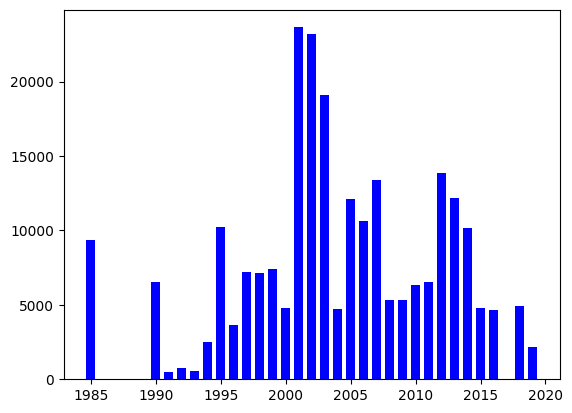

In [13]:
# display a cross table of number of people's occupation by year

df_occ_year = pd.DataFrame(df_1_3.groupby("Year")["Occupation"].count())
display(df_occ_year.head())
plt.bar(df_occ_year.index, df_occ_year["Occupation"], color = 'blue', width = 0.7)

### Cleaning and re-coding unaggrevated occupation data  

As occupational data from the graph database are extracted directly from the raw datasets, specific occupation titles are repeated, such as 'agricultural worker' and 'Agricultural worker' etc. Given the raw data in the database is directly drawn from heterogeneous sources, it's reasonable to believe that duplicates (upon manual inspection) will exist despite the transformation process. Below re-code all occupations titles that are explicitly labelled `missing`, `not applicable`, `other` or something similiar to `NA` or other erroneous by removing them from the unaggregated dataset.

To reduce the complexity of the labels (and improve it's distribution), we have used unsupervised text classification to map occupational data (based on the current occupation titles which are explicitly labelled in the dataset) to the _International Standard Classification of Occupations (ISCO-08)_ codes. More information about this taxonomy can be access [here](https://isco-ilo.netlify.app/en/isco-08/).

In [14]:
# remove duplicates (upon manual inspection)
df_1_3.loc[df_1_3['Occupation'] == 'armed forces', 'Occupation'] = 'armed force'
df_1_3.loc[df_1_3['Occupation'] == 'directors and chief executives of enterprises', 'Occupation'] = 'directors and chief executives'
df_1_3.loc[df_1_3['Occupation'] == 'don t know', 'Occupation'] = 'dont know'
df_1_3.loc[df_1_3['Occupation'] == 'electrical engineering technicians', 'Occupation'] = 'electrical engineers'
df_1_3.loc[df_1_3['Occupation'] == 'employer  manager of establishment with less than    employees', 'Occupation'] = 'employer manager of establishment with less than X employees'
df_1_3.loc[df_1_3['Occupation'] == 'employer manager of establishment with less than    employes  less    emp', 'Occupation'] = 'employer manager of establishment with less than X employees'
df_1_3.loc[df_1_3['Occupation'] == 'employer manager of establishment with less than    employees', 'Occupation'] = 'employer manager of establishment with less than X employees'
df_1_3.loc[df_1_3['Occupation'] == 'missing not available', 'Occupation'] = 'missing'
df_1_3.loc[df_1_3['Occupation'] == 'modern health ass.profess.nec', 'Occupation'] = 'modern health assessment professional'
df_1_3.loc[df_1_3['Occupation'] == 'modern health ass.professionals', 'Occupation'] = 'modern health assessment professional'
df_1_3.loc[df_1_3['Occupation'] == 'never had job', 'Occupation'] = 'never had a job'
df_1_3.loc[df_1_3['Occupation'] == 'non manual   office worker   non sup', 'Occupation'] = 'non-manual office worker non-supervisor'
df_1_3.loc[df_1_3['Occupation'] == 'non manual   office worker  non supervisor', 'Occupation'] = 'non-manual office worker non-supervisor'
df_1_3.loc[df_1_3['Occupation'] == 'other  cs', 'Occupation'] = 'other'
df_1_3.loc[df_1_3['Occupation'] == 'power production rel.plant operators', 'Occupation'] = 'power production plant operators'
df_1_3.loc[df_1_3['Occupation'] == 'professional worker lawyer  accountant  teacher  etc', 'Occupation'] = 'professional worker lawyer'
df_1_3.loc[df_1_3['Occupation'] == 'professional worker lawyer  accounta', 'Occupation'] = 'professional worker lawyer'
df_1_3.loc[df_1_3['Occupation'] == 'supervisory   office worker   superv', 'Occupation'] = 'supervisory office worker'
df_1_3.loc[df_1_3['Occupation'] == 'supervisory   office worker  supervises others', 'Occupation'] = 'supervisory office worker'
df_1_3.loc[df_1_3['Occupation'] == 'unskilled manual', 'Occupation'] = 'unskilled manual worker'
df_1_3.loc[df_1_3['Occupation'] == 'company officer', 'Occupation'] = 'officer company'
df_1_3.loc[df_1_3['Occupation'] == 'worker agricultural', 'Occupation'] = 'agricultural worker'
df_1_3.loc[df_1_3['Occupation'] == 'company officer', 'Occupation'] = 'officer company'
df_1_3.loc[df_1_3['Occupation'] == 'officer field', 'Occupation'] = 'field officer'

# re-code 'other'
df_1_3['Occupation'] = df_1_3['Occupation'].replace(['jp kg tj  other other'], 'other')

# re-code 'missing', 'not applicable', etc.
df_1_3['Occupation'] = df_1_3['Occupation'].replace(['missing'], np.nan)
df_1_3['Occupation'] = df_1_3['Occupation'].replace(['skip not applicable missing'], np.nan)
df_1_3['Occupation'] = df_1_3['Occupation'].replace(['not applicable'], np.nan)
df_1_3['Occupation'] = df_1_3['Occupation'].replace(['dont know'], np.nan)
df_1_3['Occupation'] = df_1_3['Occupation'].replace(['no answer'], np.nan)
df_1_3['Occupation'] = df_1_3['Occupation'].replace(['don t want to answer'], np.nan)
df_1_3['Occupation'] = df_1_3['Occupation'].replace(['don t know'], np.nan)
df_1_3['Occupation'] = df_1_3['Occupation'].replace(['missing  not available'], np.nan)

# output to notes and csv file
display(df_1_3)
df_1_3.to_csv("occupation_data.csv")

,Year,Wave,Person,Occupation
0,2019,14,446070441,clerical for example secretary clerk offic...
1,2019,14,446070440,other
2,2019,14,446070443,professional and technical for example docto...
3,2019,14,446070444,professional and technical for example docto...
4,2019,14,446070448,professional and technical for example docto...
...,...,...,...,...
283010,1985,1,3329001316,NaN
283011,1985,1,3329001317,wholesale and retail owners
283012,1985,1,3335100406,agricultural and animal husbandry workers
283013,1985,1,3335200705,furniture makers and related woodware makers


### Unsupervised machine learning using occupational title

The next segment of these notes uses Title2Vec embeddings by [Junhua Liu et al.](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-022-00649-5) to tag labels on occupational titles for data mining and analysis. Unsupervised text classification is used to classify occupation titles based on the  **RES**ponsibility, **FUN**ction, **LOC**ation, **O**thers scheme, and further tagging of **BIOES** scheme. This embedding has been pre-trained on occupational job titles from Asia (Singapore) and United States (Denvar). See more information [here](https://dl.acm.org/doi/10.1145/3406865.3418329).

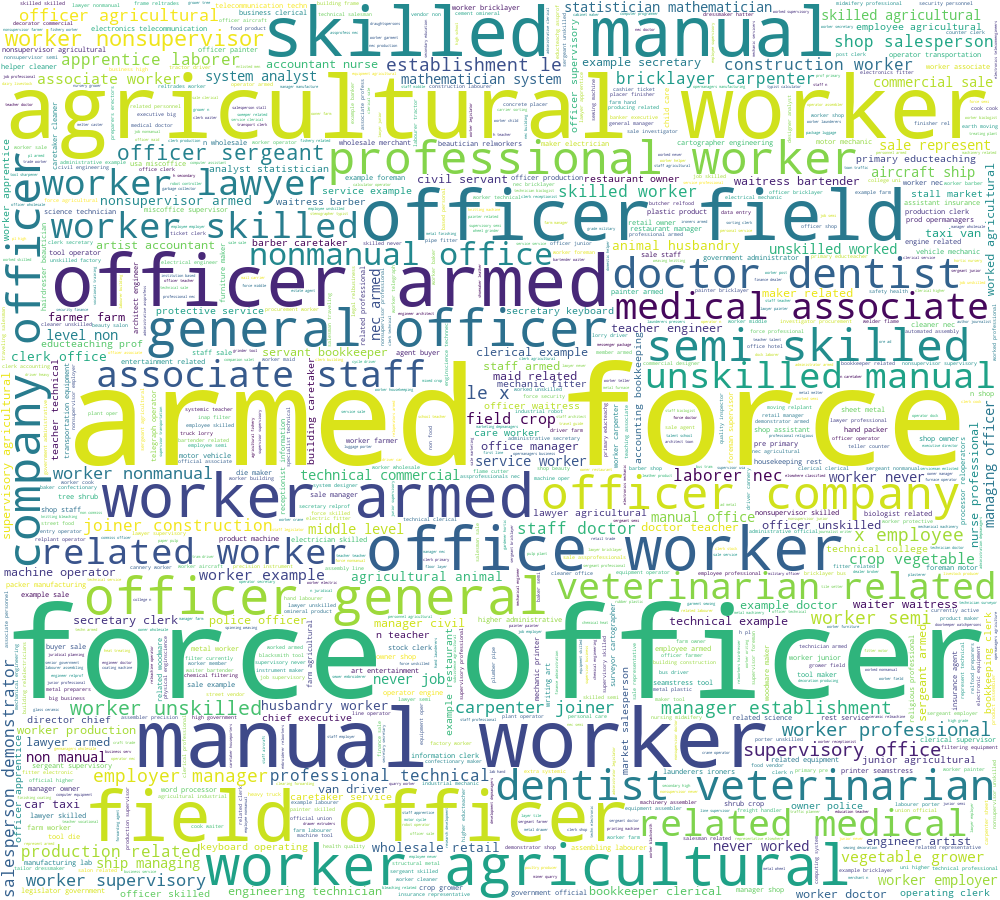

In [127]:
# re-code labels using unsupervised ML of occupation title
df = pd.read_csv('occupation_data.csv')

## clean occupation data
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())    
    ## Tokenize (convert from string to list)
    lst_text = text.split()    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]          
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]              
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]            
    ## back to string from list
    text = " ".join(lst_text)
    return text

dtf = [1]
lst_stopwords = nltk.corpus.stopwords.words("english")
dtf[0] = df["Occupation"].apply(lambda x: 
    utils_preprocess_text(x, flg_stemm = False, flg_lemm = True, lst_stopwords = lst_stopwords)
)

## explore occupation data using word cloud (include removing nan)
long_string = ','.join(list(dtf[0].values))
long_string = long_string.replace(',nan', '')
long_string = long_string.replace(',nan,', ',')
wordcloud = WordCloud(background_color = "white", 
                      max_words = 1000000, 
                      contour_width = 100, 
                      contour_color = 'steelblue',
                      width = 1000,
                      height = 900)
wordcloud.generate(long_string)
wordcloud.to_image()


### Similarity-based text classification using KNN and Title2Vec as text embedding

Using a similarity-based text classification approach, below uses one-hot encoding to create token and label description embeddings, before matching the text and labels using cosine similarities and KNN model.

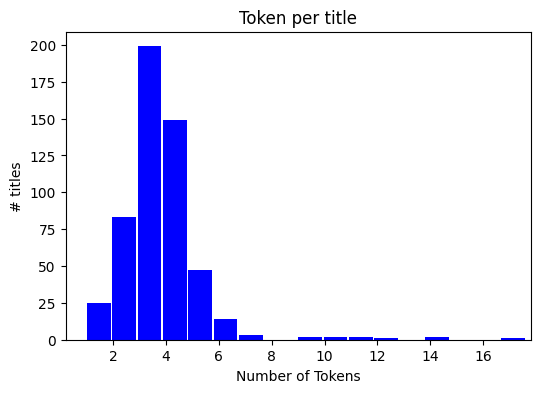

In [718]:
from flair.data import Sentence
from flair.embeddings import FlairEmbeddings

# use title2vec embeddings on occupation titles and prepare input dataset
title2vec_embed = FlairEmbeddings("title2vec-lm.pt")
job_title = [title for title in dtf[0] if title != "nan" and title != ""]
pd.DataFrame(pd.DataFrame(job_title).value_counts()).to_csv("titles_data.csv")

# get embeddings for the job titles
df_titles = pd.read_csv("titles_data.csv")
titles = []
for title in df_titles["Unnamed: 0"].values.tolist():
    s_jobtitle = Sentence(title)  
    title2vec_embed.embed(s_jobtitle)
    titles.append(s_jobtitle)
    
# prepare embeddings for labels using RESponsibility, FUNction, LOCation, Others scheme 
# further tagging using Beginning, Inside, Others, Ending and Single -- BIOES Scheme
title_labels = ['RES', 'FUN', 'LOC', 'O', 
                'B-RES', 'I-RES', 'O-RES', 'E-RES', 'S-RES', 
                'B-FUN', 'I-FUN', 'O-FUN', 'E-FUN', 'S-FUN',
                'B-LOC', 'I-LOC', 'O-LOC', 'E-LOC', 'S-LOC']
labels_embed = []
for label in title_labels:
    lbl = Sentence(label)
    title2vec_embed.embed(lbl)
    for token in lbl:
        embedding = token.embedding.numpy()
        labels_embed.append(embedding)

# plot number of titles verse number of tokens per title
plt.hist([len(token) for token in titles], 
         bins = 50, 
         color = 'blue', 
         width = 0.9)
plt.rcParams["figure.figsize"] = (6, 4)
plt.title('Token per title')
plt.xlabel('Number of Tokens')
plt.ylabel('# titles')
plt.show()

In [579]:
# prepare X, y for zero-shot learning
X = labels_embed
y = []
data_ner = {"title #":[], "tokens":[], "words":[]}
i = 0
for title in titles:
    i = i + 1
    for token in title:
        w_embedding = np.array(token.embedding.numpy())
        t_embedding = token.embedding
        y.append([i, w_embedding, t_embedding])
        data_ner["title #"].append(i)
        data_ner["tokens"].append(token)
        data_ner["words"].append(token.text)
data_ner = pd.DataFrame.from_dict(data_ner)
display(data_ner)

,title #,tokens,words
0,1,"Token[0]: ""agricultural""",agricultural
1,1,"Token[1]: ""worker""",worker
2,2,"Token[0]: ""armed""",armed
3,2,"Token[1]: ""force""",force
4,2,"Token[2]: ""officer""",officer
...,...,...,...
1836,529,"Token[0]: ""farm""",farm
1837,529,"Token[1]: ""technician""",technician
1838,530,"Token[0]: ""mathematician""",mathematician
1839,530,"Token[1]: ""statistician""",statistician


In [738]:
# implement embedding using KNN model
# unable to use Flair for this task as it doesn't have the right models, instead using sklearn models
from sklearn.neighbors import NearestNeighbors
from scipy import spatial

neigh = NearestNeighbors(n_neighbors = 3, radius = 0.8, metric = spatial.distance.cosine)
neigh.fit(X)

NearestNeighbors(metric=<function cosine at 0x136d0d670>, n_neighbors=3,
                 radius=0.8)

In [581]:
# get labels for each job title using KNN model
token_prediction = []
token_prediction_distance = []
for i in range(len(y)):
    embed = y[i][1]
    closest_label = neigh.kneighbors([embed], return_distance = False)[0, 0]
    label_closest_distance = neigh.kneighbors([embed])[0][0][0]
    tag = title_labels[closest_label]
    token_prediction.append(tag)
    token_prediction_distance.append(label_closest_distance)
data_ner["tags"] = token_prediction
data_ner["closest distance"] = token_prediction_distance

display(data_ner)

,title #,tokens,words,tags,closest distance
0,1,"Token[0]: ""agricultural""",agricultural,E-FUN,0.859928
1,1,"Token[1]: ""worker""",worker,O-RES,0.840549
2,2,"Token[0]: ""armed""",armed,I-RES,0.912650
3,2,"Token[1]: ""force""",force,O-LOC,0.786185
4,2,"Token[2]: ""officer""",officer,S-LOC,0.829765
...,...,...,...,...,...
1836,529,"Token[0]: ""farm""",farm,FUN,0.748070
1837,529,"Token[1]: ""technician""",technician,S-LOC,0.790430
1838,530,"Token[0]: ""mathematician""",mathematician,S-LOC,0.839863
1839,530,"Token[1]: ""statistician""",statistician,O-LOC,0.822410


<Axes: title={'center': 'Title2Vec Tags in Occupation Title'}, xlabel='Title2Vec Tags', ylabel='# Tags'>

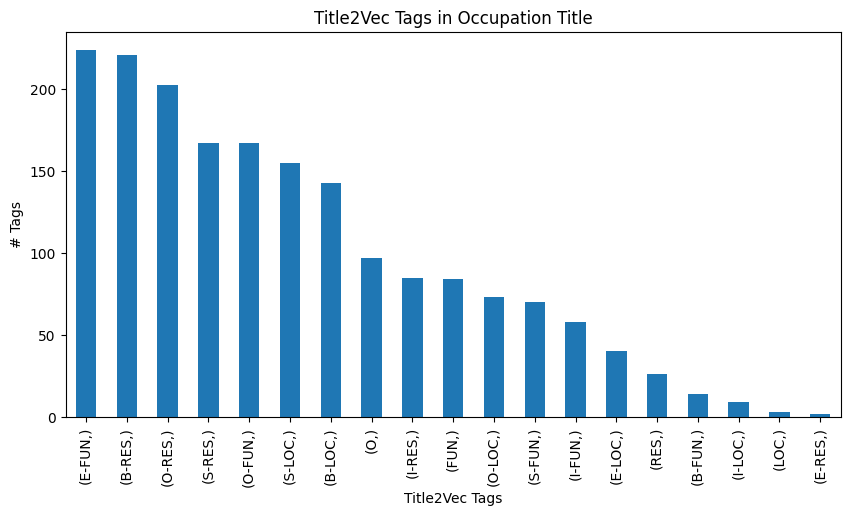

In [582]:
pd.DataFrame(token_prediction).value_counts().plot(kind = "bar", 
                                                   figsize = (10,5), 
                                                   title = "Title2Vec Tags in Occupation Title",
                                                   xlabel = "Title2Vec Tags",
                                                   ylabel = "# Tags")

### Feature engineering using Part-of-Speech (POS) and Title2Vec 

_**Title2Vec**_ tagging scheme:

- **RES** : tokens that are associated with the level of responsibility related to the job. It can be divided into managerial level (manager, director, president etc.), operational role (technician, engineer, accountant etc.), and seniority (junior, senior, chief). 
- **FUN** : tokens that are associated with the business function within a company. It can be divided into departments (marketing, operations, finance etc.), scope of work (enterprise, national, international etc.), and content (security, education, and R&D)
- **LOC** : tokens that are associated with geographic location of the job. It can be divided into regions (Asia, USA etc.), and Countries/States/Cities (Taiwan, Northern Taiwan, New Taipei City).  
- **O** : tokens that are outside the other three categories


_**BIOES**_ tagging scheme:

- **B** : token that begins a span
- **I** : tokens inside a span
- **O** : tokens outside of any span
- **E** : token that ends a span
- **S** : token that gets single span


_**ISCO-08**_ major groups:

1. Managers
2. Professionals
3. Technicians and Associate Professionals
4. Clerical Support Workers
5. Service and Sales Workers
6. Skilled Agricultural, Forestry and Fishery Workers
7. Craft and Related Trades Workers
8. Plant and Machine Operators, and Assemblers
9. Elementary Occupations
10. Armed Forces Occupations


<table>
  <tr>
    <th>ISCO-08</th>
    <th>Most frequent words (with related tags)</th>
  </tr>
  <tr>
    <th></th>
    <th>RES</th>
    <th>FUN</th>
    <th>LOC</th>
    <th>O</th>
  </tr>
  <tr>
    <td>x</td>
    <td>x</td>
    <td>x</td>
    <td>x</td>
    <td>x</td>
  </tr>
</table>

Mapping of _**ISCO-08**_ major groups with words and tags:

| ISCO-08 | Most frequent words (with related tags) |
| :------------------------------ | :----------- |
| Managers | manger (B-RES, O), depmanagers (I-RES), opermanagers (O-RES), genmanager (O-RES), senofficials (I-RES), higher (RES), high (RES), middle (RES), supervisory (S-FUN), chief (S-FUN), supervisor (S-LOC), executive (LOC), government (E-LOC), owner (B-LOC, O-LOC), legislator (S-LOC), official (O), director (O)  |
| Professionals | assprofessional (O-RES), prof (RES), engineer (S-RES), senior (S-FUN), legal (S-FUN), business (S-FUN), civil (E-FUN), principal (I-FUN), professional (I-FUN, E-FUN), assprof (I-LOC), adviser (O) |
| Technicians and Associate Professionals | skilled (B-RES), dentist (0-RES), associate (S-FUN, O-FUN), engine (O-FUN), engineering (S-FUN), inspector (I-RES, O-RES), electronic (I-FUN), computer (I-FUN), photographic (I-FUN), architect (I-FUN), medical (E-FUN), statistical (S-FUN), veterinarian (B-LOC), junior (O-LOC), economist (E-LOC), techn (O-LOC), botanist (O-LOC), technician (S-LOC), doctor (S-LOC), pilot (S-LOC), anthropologist (O), astronomer (O), sociologist (O), pathologist (O), geophysicist (O), geologist (O) |
| Clerical Support Workers | tax (RES), processing (B-RES), computing (B-RES), bookkeeper (I-RES), clerk (O-RES), entry (E-RES), office (FUN), telephone (I-FUN), administrative (B-LOC), buyer (O-LOC), secretary (S-LOC) |
| Service and Sales Workers | serv (RES), tax (RES), agent (RES, O-FUN), service (S-RES, E-LOC, O), police (S-RES), bus (FUN), shop (FUN), merchant (B-FUN), sale (O-FUN), finance (O-LOC), buyer (O-LOC), hotel (E-LOC), salesman (S-LOC), salesperson (S-LOC), cook (O), waiter (O)|
| Skilled Agricultural, Forestry and Fishery Workers | farmer (B-RES), forestry (B-RES), farm (FUN), prod (E-FUN), market (E-FUN), animal (S-FUN), hortic (I-LOC), crop (O-LOC) |
| Craft and Related Trades Workers| bricklayer (O-RES), painter (I-RES), dresser (I-RES), moulders (S-RES), finisher (S-RES), building (B-RES), metal (B-RES), wood (FUN), door (FUN), hand (FUN), maker (FUN), composer (I-FUN), ceramic (I-FUN), photographic (I-FUN), craft (I-FUN), art (I-FUN), handicraft (O-FUN), printing (E-FUN), glass (E-FUN), singer (S-FUN), surveyor (O-LOC), maker (S-LOC, O), cartographer (O), author (O), writer (O) |
| Plant and Machine Operators, and Assemblers| plant (B-RES, B-LOC), oper (O-RES, S-RES), machine (S-RES), equipment (S-RES), fitter (S-RES), machinery (S-RES), moulders (S-RES), crane (FUN), machine (I-FUN, S-FUN), automated (I-FUN), mining (E-FUN), assembler (S-LOC), construction (E-LOC), aircraft (B-LOC) |
| Elementary Occupations | labourer (S-RES, I-RES), cleaner (I-RES), unskilled (B-RES), caretaker (I-RES), weaving (B-FUN), school (B-FUN), transport (B-FUN), food (E-FUN), care (O-FUN), teacher (B-LOC, E-LOC, O), educteacher (S-FUN, O-LOC), maintenance (E-LOC), assembler (S-LOC), mechanic (S-LOC), domestic (I-LOC), union (I-LOC), safety (E-LOC), education (E-LOC), undertaker (O)  |
| Armed Forces Occupations| armed (O-RES, I-RES), force (O-LOC) |


In [584]:
# re-shape NER data with tag features 
def empty_title_feature(title_feature):
    title_feature = {"RES":0, "FUN":0, "LOC":0, "O":0, "B-RES":0, 
                     "I-RES":0, "O-RES":0, "E-RES":0, "S-RES":0,
                     "B-FUN":0, "I-FUN":0, "O-FUN":0, "E-FUN":0, 
                     "S-FUN":0, "B-LOC":0, "I-LOC":0, "O-LOC":0, 
                     "E-LOC":0, "S-LOC":0}
    return title_feature
data_title_long = pd.DataFrame.from_dict({"#":[], "description":[], "features":[]})
data_title_short = pd.DataFrame.from_dict(data_ner)
title_no = []
title_des = []
title_features = []
title = ""
i = 1
title_feature = empty_title_feature(title_feature = [])
for index in data_title_short.index:
    if data_title_short["title #"][index] == i:
        title = title + " " + data_title_short["words"][index]
    else:
        title_no.append(i)
        title_des.append(title)
        title_features.append(title_feature)
        title = ""
        title = title + " " + data_title_short["words"][index]         
        title_feature = empty_title_feature(title_feature)
        i = i + 1
    tag = data_title_short["tags"][index]
    title_feature[tag] = title_feature[tag] + 1
data_title_long["#"] = title_no
data_title_long["description"] = title_des  
data_title_long["features"] = title_features
display(data_title_long)                                       

,#,description,features
0,1,agricultural worker,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 0, 'B-RES'..."
1,2,armed force officer field officer,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 0, 'B-RES'..."
2,3,armed force officer general officer,"{'RES': 1, 'FUN': 0, 'LOC': 0, 'O': 1, 'B-RES'..."
3,4,skilled manual worker,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 0, 'B-RES'..."
4,5,armed force officer company officer,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 1, 'B-RES'..."
...,...,...,...
524,525,social work professional,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 0, 'B-RES'..."
525,526,geologist geophysicist,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 2, 'B-RES'..."
526,527,air traffic pilot,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 0, 'B-RES'..."
527,528,midwifery associate professional,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 0, 'B-RES'..."


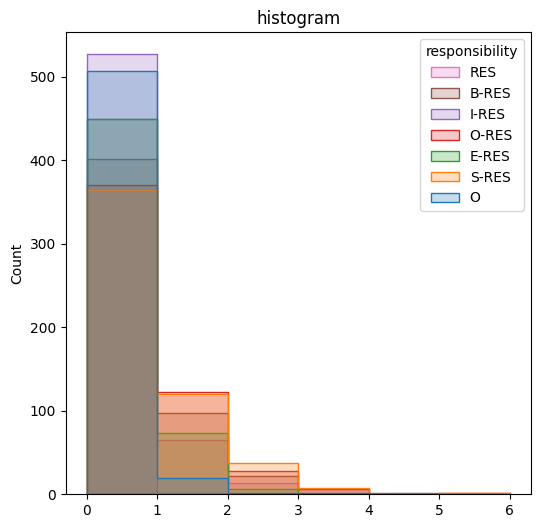

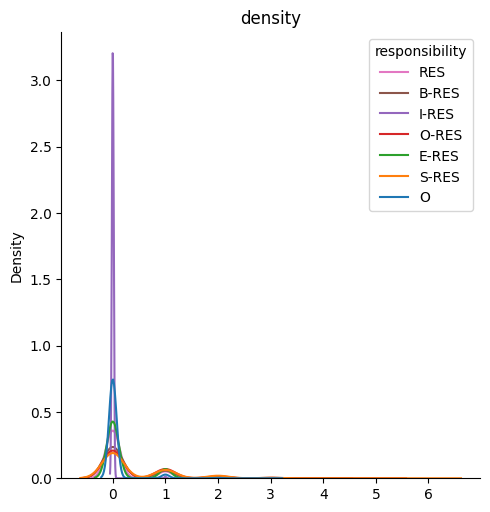

In [697]:
def construct_list_for_plot(title_lbl):
    list_title = []
    title_str = ""
    title_feature = 0
    features = [0] * len(title_lbl)
    i = 0
    for idx in data_title_long.index:
        title_str = (data_title_long["description"][idx]).strip()
        for lbl in title_lbl:
            title_feature = data_title_long["features"][idx][lbl]
            features[i] = title_feature
            i = i + 1
        row_title = [title_str] + features
        list_title.append(row_title)
        i = 0
    df_titles = pd.DataFrame(list_title)
    df_titles.columns = ["title"] + title_lbl
    x1 = df_titles.iloc[0:len(df_titles), 1]
    x2 = df_titles.iloc[0:len(df_titles), 2]
    x3 = df_titles.iloc[0:len(df_titles), 3]
    x4 = df_titles.iloc[0:len(df_titles), 4]
    x5 = df_titles.iloc[0:len(df_titles), 5]
    x6 = df_titles.iloc[0:len(df_titles), 6]
    x7 = df_titles.iloc[0:len(df_titles), 7]
    return [x1, x2, x3, x4, x5, x6, x7]

def construct_list_for_barplot(title_lbl):
    cluster_tn = []
    tn = []
    for lbl in title_lbl:    
        cluster_tn = data_ner[data_ner["tags"] == lbl]
        cluster_tn = cluster_tn.groupby("tags")["words"].value_counts()\
                                                        .reset_index()\
                                                        .sort_values("count", ascending = False)
        cluster_tn["tags"] = lbl
        tn.append(cluster_tn)
    return pd.concat(tn)

# Occupational responsibilities

title_lbl = ["RES", "B-RES", "I-RES", "O-RES", "E-RES", "S-RES", "O"]

sns.histplot(construct_list_for_plot(title_lbl),
             kde = False, 
             common_norm = False,
             element = "step", 
             binwidth = 1.0)
plt.rcParams["figure.figsize"] = (6, 6)
plt.title("histogram")
plt.legend(labels = title_lbl, title = "responsibility")

sns.displot(construct_list_for_plot(title_lbl),  
            kind = "kde",
            legend = False)
plt.title("density")
plt.rcParams["figure.figsize"] = (6, 6)
plt.legend(labels = title_lbl, title = "responsibility")

plt.show()

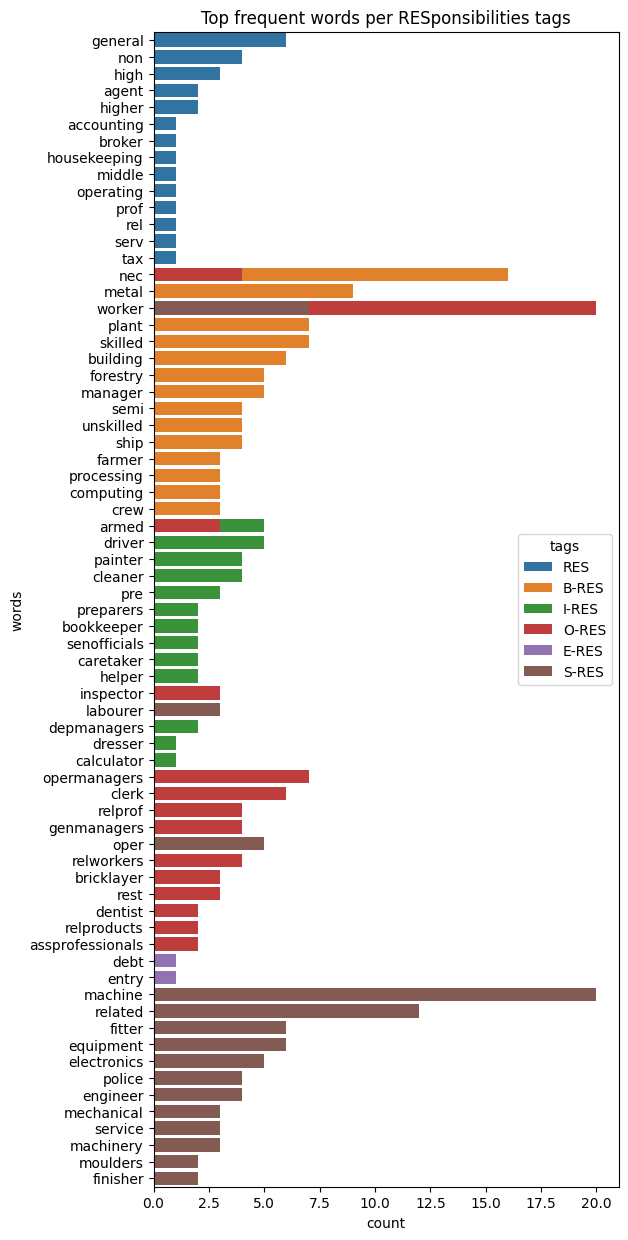

In [714]:
# Occupational responsibility categories 

title_lbl = ["RES", "B-RES", "I-RES", "O-RES", "E-RES", "S-RES"]
cluster_tn = construct_list_for_barplot(title_lbl)
x = [[],[],[],[],[],[]]
i = 0
for lbl in title_lbl:
    x[i] = (cluster_tn[cluster_tn["tags"] == lbl]).head(15)
    i = i + 1
plt.rcParams["figure.figsize"] = (6, 15)
df = pd.concat(x)
sns.barplot(x="count", y="words", hue="tags", data=df, dodge=False, orient="h")
plt.title("Top frequent words per RESponsibilities tags")
plt.show()


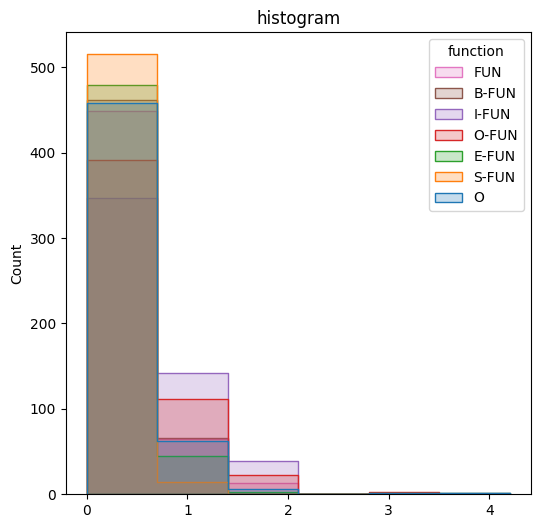

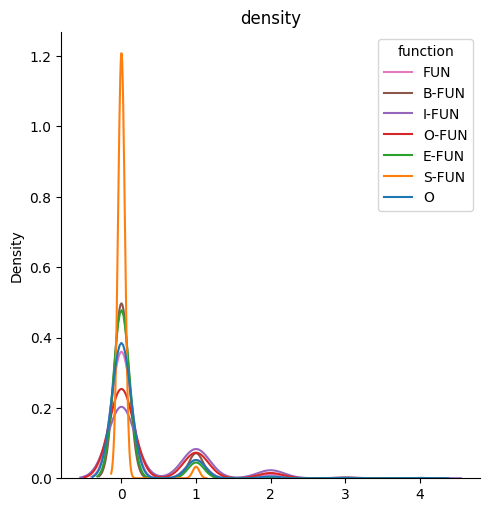

In [696]:
# Occupational function

title_lbl = ["FUN", "B-FUN", "I-FUN", "O-FUN", "E-FUN", "S-FUN", "O"]

sns.histplot(construct_list_for_plot(title_lbl),
             kde = False, 
             common_norm = False,
             element = "step", 
             binwidth = 0.7)
plt.rcParams["figure.figsize"] = (6, 6)
plt.title("histogram")
plt.legend(labels = title_lbl, title = "function")

sns.displot(construct_list_for_plot(title_lbl),  
             kind = "kde",
             legend = False)
plt.title("density")
plt.rcParams["figure.figsize"] = (6, 6)
plt.legend(labels = title_lbl, title = "function")

plt.show()


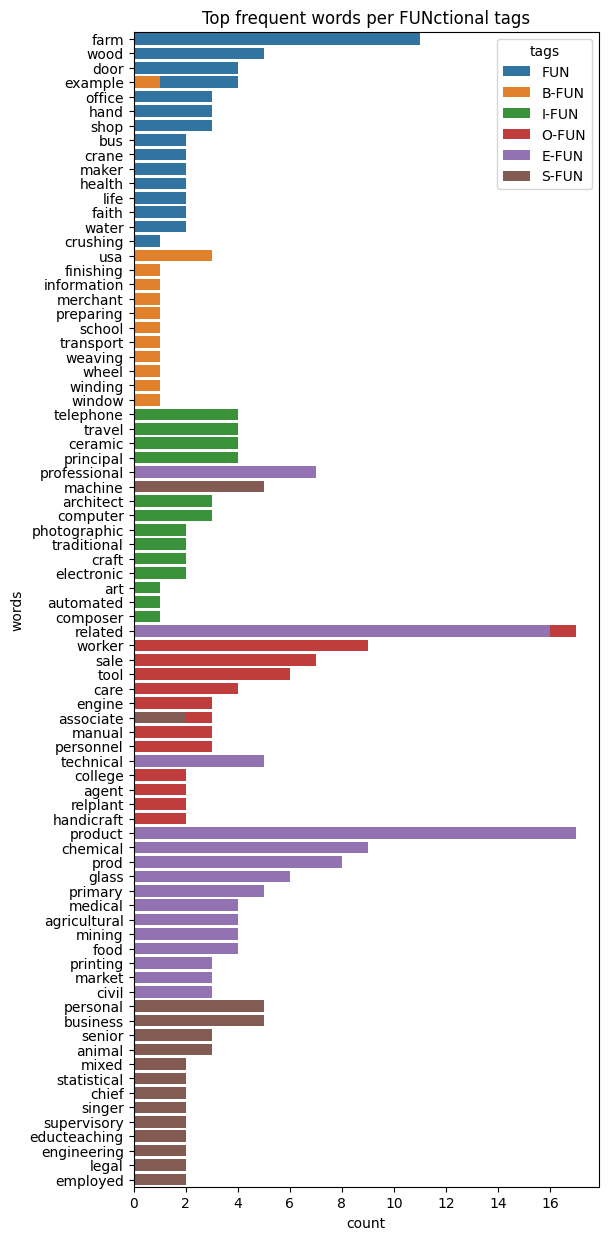

In [713]:
# Occupational function categories 

title_lbl = ["FUN", "B-FUN", "I-FUN", "O-FUN", "E-FUN", "S-FUN"]
cluster_tn = construct_list_for_barplot(title_lbl)
x = [[],[],[],[],[],[]]
i = 0
for lbl in title_lbl:
    x[i] = (cluster_tn[cluster_tn["tags"] == lbl]).head(15)
    i = i + 1
plt.rcParams["figure.figsize"] = (6, 15)
df = pd.concat(x)
sns.barplot(x="count", y="words", hue="tags", data=df, dodge=False, orient="h")
plt.title("Top frequent words per FUNctional tags")
plt.show()


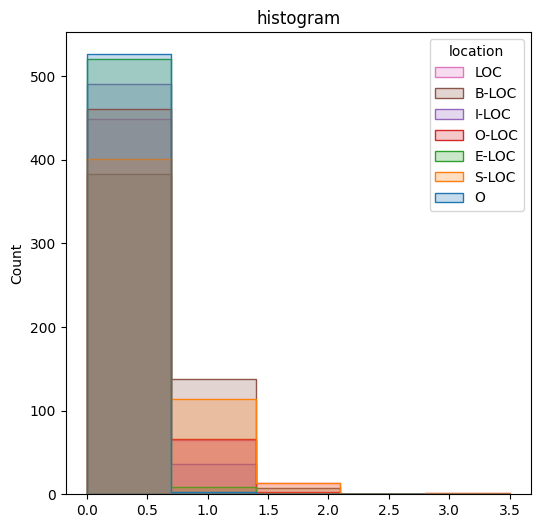

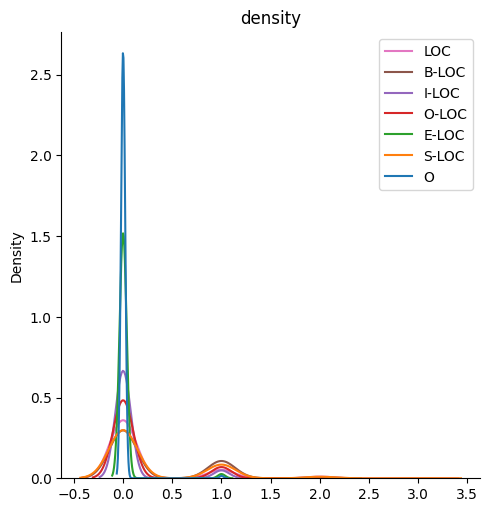

In [700]:
# Occupational responsibilities

title_lbl = ["LOC", "B-LOC", "I-LOC", "O-LOC", "E-LOC", "S-LOC", "O"]

sns.histplot(construct_list_for_plot(title_lbl),
             kde = False, 
             common_norm = False,
             element = "step", 
             binwidth = 0.7)
plt.rcParams["figure.figsize"] = (6, 6)
plt.title("histogram")
plt.legend(labels = title_lbl, title = "location")

sns.displot(construct_list_for_plot(title_lbl),  
             kind = "kde",
             legend = False)
plt.title("density")
plt.rcParams["figure.figsize"] = (6, 6)
plt.legend(labels = title_lbl, title = "location")
plt.legend(labels = title_lbl)

plt.show()


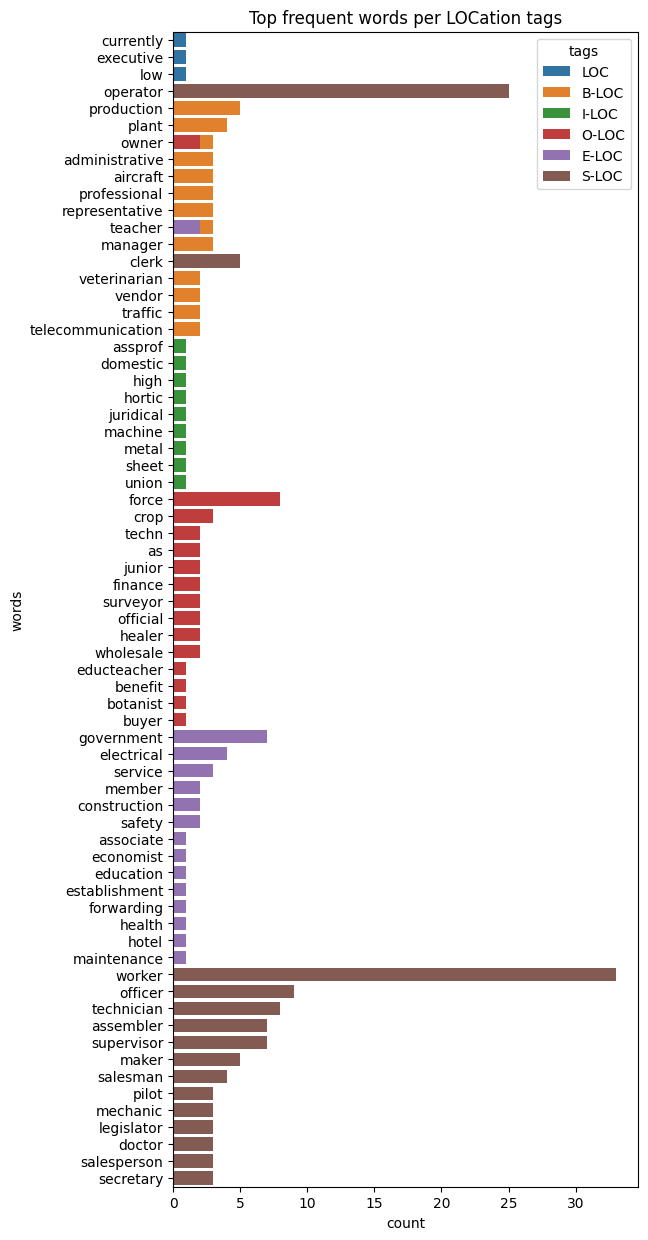

In [711]:
# Occupational function categories 

title_lbl = ["LOC", "B-LOC", "I-LOC", "O-LOC", "E-LOC", "S-LOC"]
cluster_tn = construct_list_for_barplot(title_lbl)
x = [[],[],[],[],[],[]]
i = 0
for lbl in title_lbl:
    x[i] = (cluster_tn[cluster_tn["tags"] == lbl]).head(15)
    i = i + 1
plt.rcParams["figure.figsize"] = (6, 15)
df = pd.concat(x)
sns.barplot(x="count", y="words", hue="tags", data=df, dodge=False, orient="h")
plt.title("Top frequent words per LOCation tags")
plt.show()


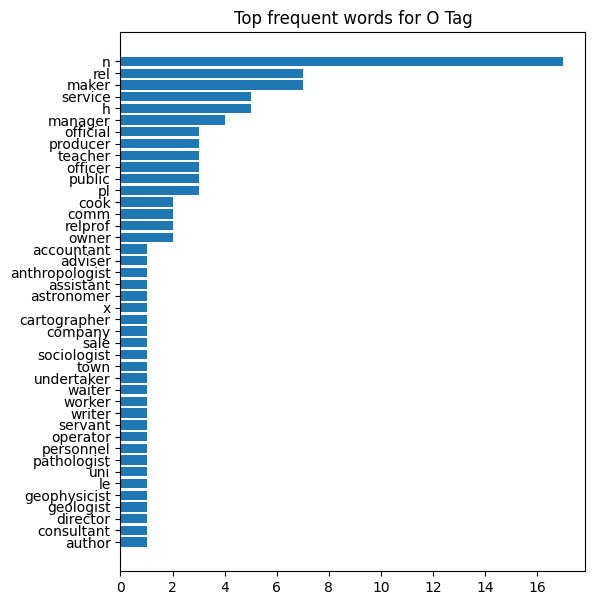

In [712]:
# Occupational outside categories (other)

title_lbl = ["O"]
cluster_tn = construct_list_for_barplot(title_lbl)
cluster_tn.sort_values("count", inplace = True)
plt.rcParams["figure.figsize"] = (6, 7)
plt.title("Top frequent words for " + title_lbl[0] + " Tag")
plt.barh(cluster_tn["words"], cluster_tn["count"])
plt.show()


### Baseline results for Title2Vec

The study by [Junhua Liu et al.](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-022-00649-5) present results for name entity recognition evaluation using Title2Vec embedding. These are comparative baseline for the similarity approach. Results of high performing classifier using LSTM, CRF, and LSTM-CRF are shown below for name entity recognition task. 


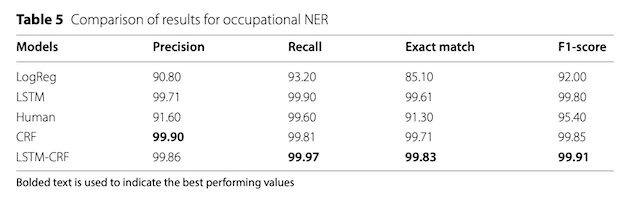

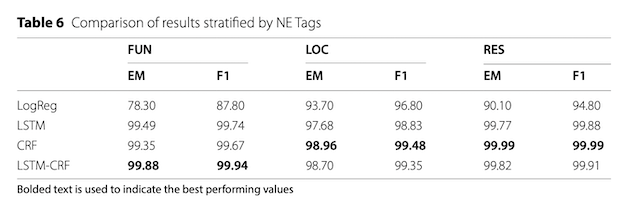

In [736]:
from PIL import Image

img_model_performance = Image.open("./resources/title2vec_ner_task_model.png")
img_tag_performance = Image.open("./resources/title2vec_ner_task_tags.png")

display(img_model_performance)
display(img_tag_performance)

### Zero-shot learning using Sentence-BERT model

At a sentence level, BERT was used to identify cosine similarities with ISCO-08 major occupation groups and title descriptions.

In [740]:
from transformers import AutoTokenizer, AutoModel
from torch.nn import functional as F
tokenizer = AutoTokenizer.from_pretrained("deepset/sentence_bert")
model = AutoModel.from_pretrained("deepset/sentence_bert")

display(data_title_long)


Some weights of the model checkpoint at deepset/sentence_bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,#,description,features
0,1,agricultural worker,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 0, 'B-RES'..."
1,2,armed force officer field officer,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 0, 'B-RES'..."
2,3,armed force officer general officer,"{'RES': 1, 'FUN': 0, 'LOC': 0, 'O': 1, 'B-RES'..."
3,4,skilled manual worker,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 0, 'B-RES'..."
4,5,armed force officer company officer,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 1, 'B-RES'..."
...,...,...,...
524,525,social work professional,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 0, 'B-RES'..."
525,526,geologist geophysicist,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 2, 'B-RES'..."
526,527,air traffic pilot,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 0, 'B-RES'..."
527,528,midwifery associate professional,"{'RES': 0, 'FUN': 0, 'LOC': 0, 'O': 0, 'B-RES'..."


## <font color=purple>Plot trends over time</font>

A time series line plot can be used to examine the changing characteristics of people over time, such as different occupations, the number of children, and types of education.

### Analyse the trends in the number of participants

,Person_Count
Year,
1985,4253.0
1990,2531.0
1991,1813.5
1992,1892.5
1993,1946.0


<BarContainer object of 30 artists>

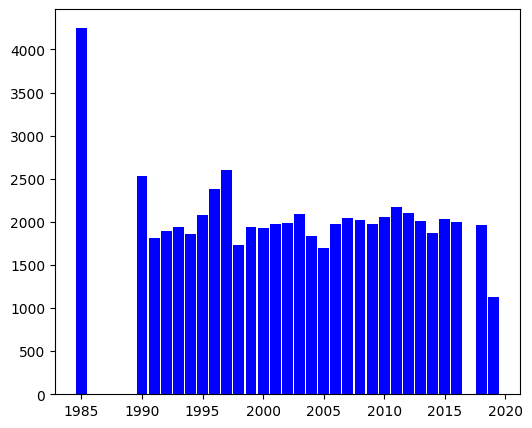

In [30]:
display(df_2_1.head())

plt.rcParams["figure.figsize"] = (6, 5)
plt.bar(df_2_1.index, 
        df_2_1["Person_Count"], 
        color = 'blue', 
        width = 0.9)

,Year,Wave,Person_Count
0,2019,14,1023
1,2019,13,1223
2,2018,58,1842
3,2018,12,2075
4,2016,56,2024
...,...,...,...
67,1990,1,1000
68,1990,3,2531
69,1990,4,2531
70,1985,1,4307


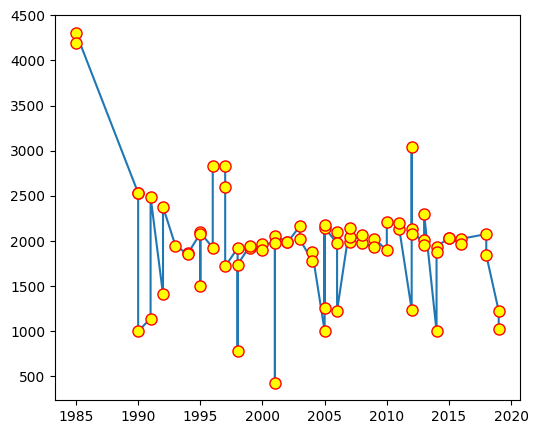

In [31]:
display(df_2_2)

plt.plot(df_2_2["Year"], df_2_2["Person_Count"], 
         marker = 'o', 
         markerfacecolor = 'yellow', 
         markeredgecolor = 'red', 
         markersize = 8)

### Analyse the trends in participant's occupation

In [32]:
# still to do ...

## <font color=purple>Interpretation of Results</font>

As we examine the plots, you can interpret the results of the analysis. Below provides a brief summary of the result addressing each of the research questions. 